# Tourist Visitors Time Series Forecasting

Anggota Kelompok:
- Muhammad Karov Ardava Barus (103052300001)
- Muhammad Alfayyedh Denof (XXXXXXXXX)
- Stephanie Maria Sianturi (XXXXXXXXX)

## Import Library & Tools

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

from statsmodels.graphics.tsaplots import plot_acf
from statsmodels.graphics.tsaplots import plot_pacf

## Data Setup

In [2]:
DATA_PATH = 'https://raw.githubusercontent.com/Ardavaa/time-series-tourist-visitors/refs/heads/main/data/data.csv'
df = pd.read_csv(DATA_PATH)

df

,Date,TouristNumber
0,33604,8414
1,33635,9767
2,33664,13805
3,33695,12987
4,33725,32190
...,...,...
283,42217,82593
284,42248,53472
285,42278,30361
286,42309,25436


In [3]:
df['Date'] = pd.date_range(start="2000-01-01", periods=len(df), freq="ME")

Cek apakah ada data missing & duplikat

In [4]:
print(f'Jumlah data missing: {df.isna().sum().sum()}')
print(f'Jumlah data duplikat: {df.duplicated().sum()}')

Jumlah data missing: 0
Jumlah data duplikat: 0


Tidak ditemukan data missing & duplikat, maka dari itu kita tidak perlu menghandle case missing / duplicate values.

Cek kestasioneran data

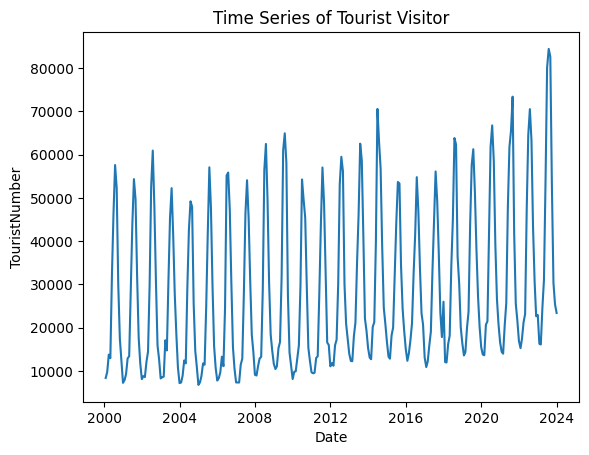

In [5]:
sns.lineplot(data=df, x='Date', y='TouristNumber')
plt.title('Time Series of Tourist Visitor')
plt.show()

## Uji Stasioner Variansi (Box-Cox)

Selain stasioner dalam rata-rata (mean), deret waktu juga idealnya memiliki variansi yang relatif konstan. Dari plot data original, terlihat indikasi variansi yang makin membesar seiring waktu (*heteroscedasticity*).

Salah satu transformasi umum untuk menstabilkan variansi adalah **Box-Cox transformation**. Di bawah ini kita estimasi parameter $\lambda$ (maksimum likelihood), lalu membandingkan data original vs data hasil transformasi serta rolling standard deviation-nya.

Box-Cox lambda (MLE): -0.081342
Shift applied        : 0.000000 (hanya jika data <= 0)


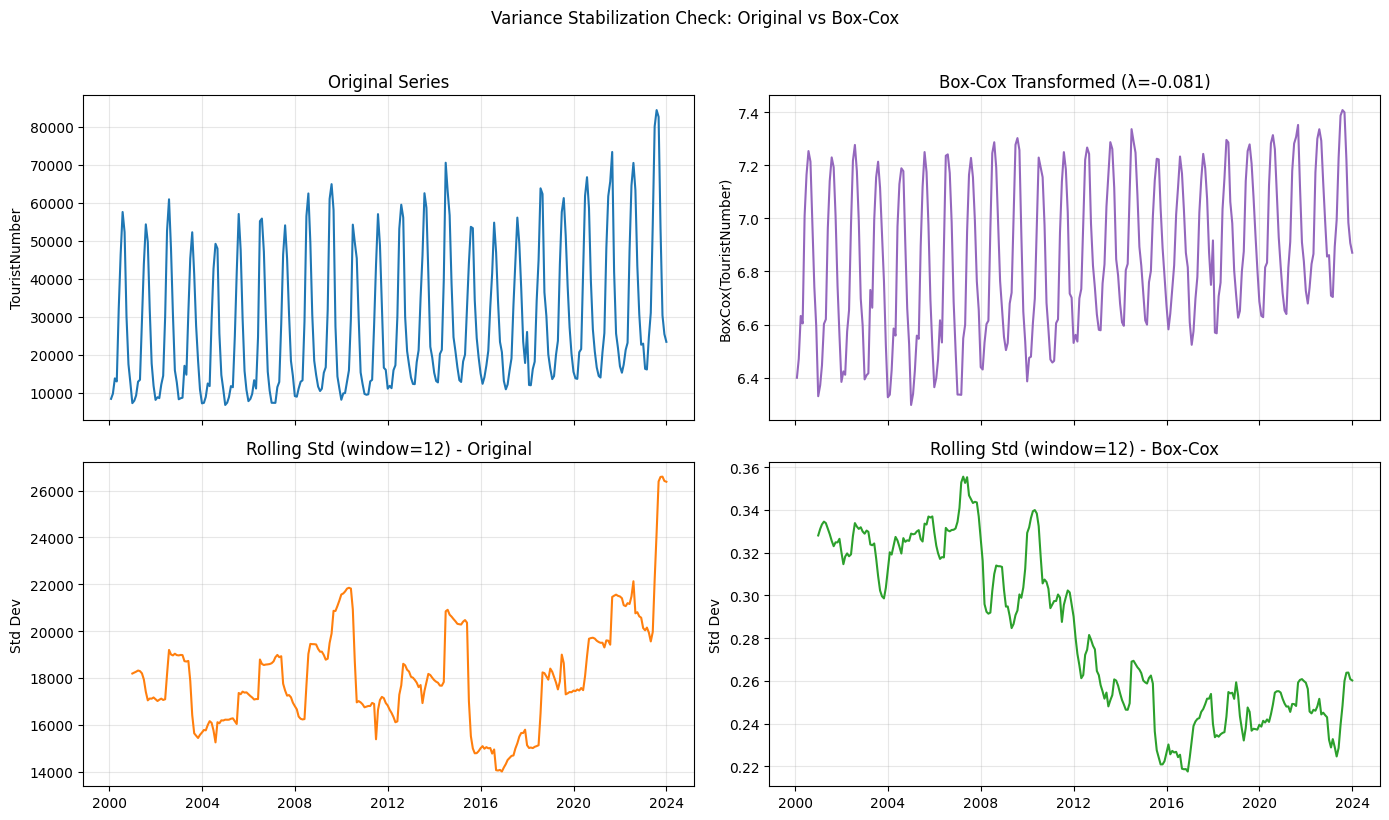

In [6]:
# Uji stasioner variansi: rolling std + Box-Cox transform
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

try:
    from scipy import stats
except Exception as e:
    raise ImportError(
        "SciPy belum tersedia. Install dulu: pip install scipy (atau conda install scipy)."
    ) from e

# Pastikan data positif untuk Box-Cox; jika tidak, lakukan shifting
y_raw = df['TouristNumber'].astype('float64').copy()
min_val = float(np.nanmin(y_raw.values))
shift = 0.0
if min_val <= 0:
    shift = 1.0 - min_val

y_pos = y_raw + shift

# Estimasi lambda (MLE) lalu transformasi Box-Cox
lam = float(stats.boxcox_normmax(y_pos.dropna().values, method='mle'))
y_bc = pd.Series(stats.boxcox(y_pos.values, lmbda=lam), index=df.index, name='TouristNumber_BoxCox')

# Simpan ke df (opsional, tapi berguna untuk analisis lanjutan)
df['TouristNumber_BoxCox'] = y_bc

print(f"Box-Cox lambda (MLE): {lam:.6f}")
print(f"Shift applied        : {shift:.6f} (hanya jika data <= 0)")

# Rolling standard deviation (misal 12 bulan) sebelum vs sesudah transformasi
window = 12
roll_std_raw = y_raw.rolling(window).std()
roll_std_bc = y_bc.rolling(window).std()

fig, axes = plt.subplots(2, 2, figsize=(14, 8), sharex=True)

axes[0, 0].plot(df['Date'], y_raw, color='tab:blue')
axes[0, 0].set_title('Original Series')
axes[0, 0].set_ylabel('TouristNumber')

axes[0, 1].plot(df['Date'], y_bc, color='tab:purple')
axes[0, 1].set_title(f'Box-Cox Transformed (λ={lam:.3f})')
axes[0, 1].set_ylabel('BoxCox(TouristNumber)')

axes[1, 0].plot(df['Date'], roll_std_raw, color='tab:orange')
axes[1, 0].set_title(f'Rolling Std (window={window}) - Original')
axes[1, 0].set_ylabel('Std Dev')

axes[1, 1].plot(df['Date'], roll_std_bc, color='tab:green')
axes[1, 1].set_title(f'Rolling Std (window={window}) - Box-Cox')
axes[1, 1].set_ylabel('Std Dev')

for ax in axes.ravel():
    ax.grid(alpha=0.3)

plt.suptitle('Variance Stabilization Check: Original vs Box-Cox', y=1.02)
plt.tight_layout()

# Simpan gambar untuk laporan
plt.savefig('boxcox-transform.png', dpi=200, bbox_inches='tight')
plt.show()

Dari gambar diatas bisa dilihat dengan jelas bahwa datanya tidak stasioner. Tapi kita akan membuktikannya lagi dengna Uji ADF.

In [7]:
from statsmodels.tsa.stattools import adfuller

def adf_test(series, title=''):
    print(f'Hasil Uji Augmented Dickey-Fuller Test (ADF): {title}')
    
    # ADF Test handles NaNs by raising error usually, so we drop them
    result = adfuller(series.dropna(), autolag='AIC') 
    
    labels = ['ADF Test Statistic', 'p-value', '# Lags Used', '# Observations Used']
    out = pd.Series(result[0:4], index=labels)
    
    for key, val in result[4].items():
        out[f'Critical Value ({key})'] = val
        
    print(out.to_string())
    
    if result[1] <= 0.05:
        print("\nKesimpulan: Bukti kuat menolak hipotesis nol")
        print("Tolak hipotesis nol")
        print("Data tidak memiliki unit root dan STASIONER")
    else:
        print("\nKesimpulan: Bukti lemah menolak hipotesis nol")
        print("Gagal menolak hipotesis nol")
        print("Data memiliki unit root dan TIDAK STASIONER")

# Uji ADF pada data original
adf_test(df['TouristNumber'], title='Original Data')

Hasil Uji Augmented Dickey-Fuller Test (ADF): Original Data
ADF Test Statistic        1.247470
p-value                   0.996298
# Lags Used              13.000000
# Observations Used     274.000000
Critical Value (1%)      -3.454444
Critical Value (5%)      -2.872147
Critical Value (10%)     -2.572422

Kesimpulan: Bukti lemah menolak hipotesis nol
Gagal menolak hipotesis nol
Data memiliki unit root dan TIDAK STASIONER


Data yang di plot tidak stasioner. maka dari itu kita akan coba melakukan differencing

In [8]:
print(f'Jumlah data missing: {df.isna().sum()}')

Jumlah data missing: Date                    0
TouristNumber           0
TouristNumber_BoxCox    0
dtype: int64


In [9]:
# Melakukan differencing pada kolom TouristNumber (Order 1)
df['TouristNumber_Diff'] = df['TouristNumber'].diff()

# Melakukan differencing pada kolom Date (akan menghasilkan selisih waktu/Timedelta)
df['Date_Diff'] = df['Date'].diff()

# Menampilkan data setelah differencing
df.head()

,Date,TouristNumber,TouristNumber_BoxCox,TouristNumber_Diff,Date_Diff
0,2000-01-31,8414,6.399663,NaN,NaT
1,2000-02-29,9767,6.470721,1353.0,29 days
2,2000-03-31,13805,6.632332,4038.0,31 days
3,2000-04-30,12987,6.604133,-818.0,30 days
4,2000-05-31,32190,7.009090,19203.0,31 days


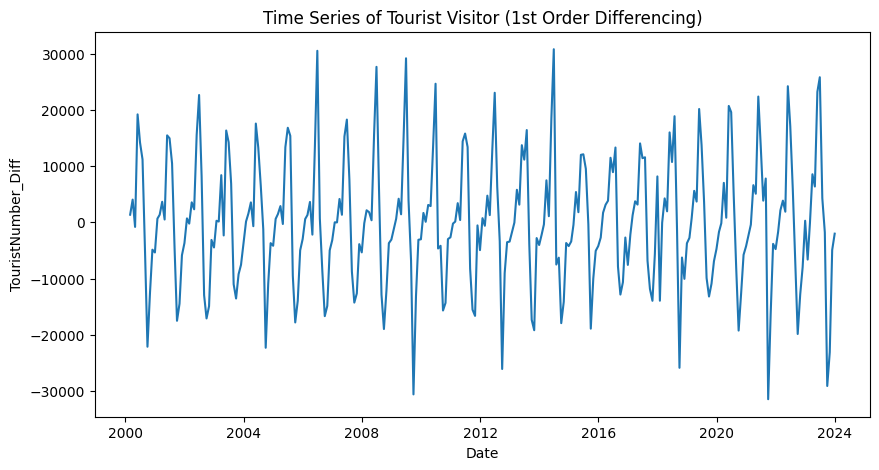

In [10]:
# Plot hasil differencing TouristNumber untuk melihat stasioneritas
plt.figure(figsize=(10, 5))
sns.lineplot(data=df, x='Date', y='TouristNumber_Diff')
plt.title('Time Series of Tourist Visitor (1st Order Differencing)')
plt.show()

In [11]:
# Uji ADF pada data setelah differencing
adf_test(df['TouristNumber_Diff'], title='1st Order Differencing')

Hasil Uji Augmented Dickey-Fuller Test (ADF): 1st Order Differencing
ADF Test Statistic     -8.170180e+00
p-value                 8.665018e-13
# Lags Used             1.200000e+01
# Observations Used     2.740000e+02
Critical Value (1%)    -3.454444e+00
Critical Value (5%)    -2.872147e+00
Critical Value (10%)   -2.572422e+00

Kesimpulan: Bukti kuat menolak hipotesis nol
Tolak hipotesis nol
Data tidak memiliki unit root dan STASIONER


## Plot ACF & PACF

In [12]:
# drop nilai missing pada data original setelah diffencing
diff_data = df['TouristNumber_Diff'].dropna()

print(f'Jumlah data missing: {diff_data.isna().sum()}')

Jumlah data missing: 0


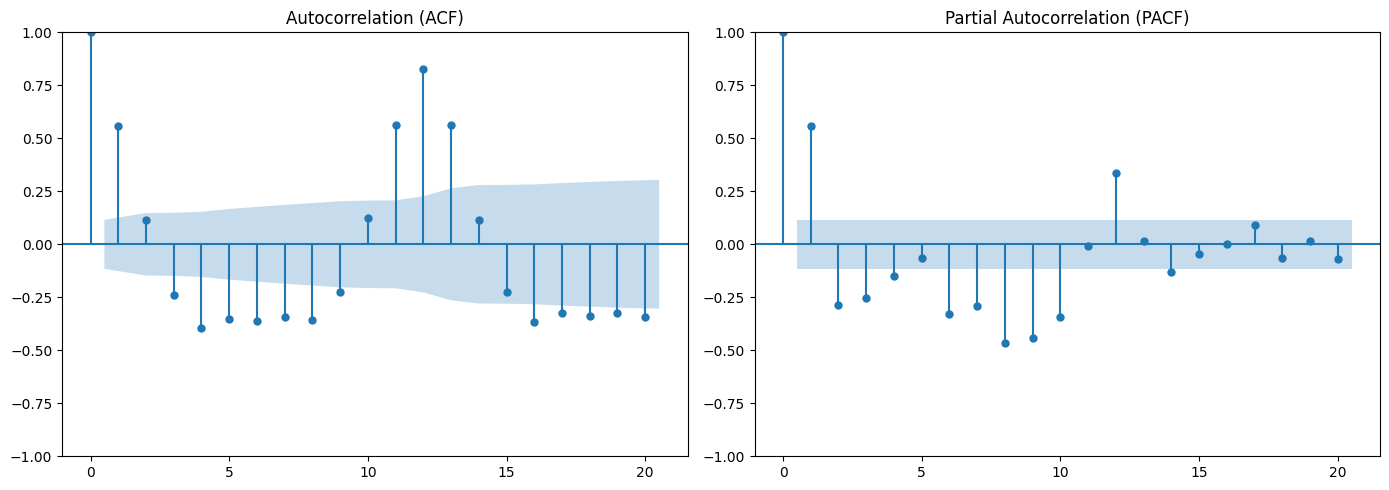

In [13]:
plt.figure(figsize=(14,5))

plt.subplot(1, 2, 1)
plot_acf(diff_data, ax=plt.gca(), lags=20)
plt.title("Autocorrelation (ACF)")

plt.subplot(1, 2, 2)
plot_pacf(diff_data, ax=plt.gca(), lags=20)
plt.title("Partial Autocorrelation (PACF)")

plt.tight_layout()
plt.show()

**Identifikasi hasil plot ACF dan PACF**:
1. Pada Plot ACF: terlihat spike (lonjakan) yang tinggi pada lag 12, begitu juga pada lag 11 & lag 13.
2. Menunjukkan adanya korelasi kuat antara data saat ini dengan data 12 periode sebelumnya. Jika ini adalah data bulanan, ini mengindikasikan pola tahunan yang sangat kuat. Oleh karena itu, model yang digunakan haruslah SARIMA (Seasonal ARIMA), bukan ARIMA biasa. Periode musiman ($s$) adalah 12.

## SARIMA Modeling (Seasonal ARIMA)

> Tujuan: memilih parameter SARIMA yang masuk akal berdasarkan indikasi musiman 12 bulanan, lalu evaluasi performa forecasting pada data uji.

In [14]:
from pathlib import Path

# Pastikan df ada; kalau belum, load dari URL lalu fallback ke file lokal
if 'df' not in globals():
    DATA_URL = 'https://raw.githubusercontent.com/Ardavaa/time-series-tourist-visitors/refs/heads/main/data/data.csv'
    try:
        df = pd.read_csv(DATA_URL)
    except Exception:
        local_path = Path('data') / 'data.csv'
        df = pd.read_csv(local_path)

# Pastikan kolom/index Date konsisten (aman dijalankan berulang)
if 'Date' in df.columns:
    df['Date'] = pd.to_datetime(df['Date'])
    # kalau Date juga sudah jadi index, buang kolomnya biar tidak ambigu
    if getattr(df.index, 'name', None) == 'Date':
        df = df.drop(columns=['Date'])
else:
    # kalau belum ada kolom Date, tapi index juga bukan Date, buat kolom Date dulu
    if getattr(df.index, 'name', None) != 'Date':
        df['Date'] = pd.date_range(start='2000-01-01', periods=len(df), freq='ME')

# Jadikan Date sebagai index jika masih berupa kolom
if 'Date' in df.columns:
    df = df.sort_values('Date').set_index('Date')
else:
    df = df.sort_index()

df = df.asfreq('ME')  # month-end frequency
y = df['TouristNumber'].astype('float64')

y.head()

Date
2000-01-31     8414.0
2000-02-29     9767.0
2000-03-31    13805.0
2000-04-30    12987.0
2000-05-31    32190.0
Freq: ME, Name: TouristNumber, dtype: float64

In [15]:
# Train-test split (umumnya: 12 bulan terakhir untuk test)
test_size = 12
if len(y) <= test_size + 24:
    # fallback kalau datanya pendek, tetap sisakan minimal 12 untuk train
    test_size = max(6, len(y)//5)

y_train = y.iloc[:-test_size]
y_test = y.iloc[-test_size:]

print('Train:', y_train.index.min().date(), '->', y_train.index.max().date(), 'n=', len(y_train))
print('Test :', y_test.index.min().date(), '->', y_test.index.max().date(), 'n=', len(y_test))

Train: 2000-01-31 -> 2022-12-31 n= 276
Test : 2023-01-31 -> 2023-12-31 n= 12


In [16]:
from statsmodels.tsa.statespace.sarimax import SARIMAX

def sarima_grid_search(y_train,
                       p_values=(0, 1, 2),
                       d=1,
                       q_values=(0, 1, 2),
                       P_values=(0, 1),
                       D=1,
                       Q_values=(0, 1),
                       s=12,
                       enforce_stationarity=False,
                       enforce_invertibility=False):
    """Grid search kecil untuk SARIMA berdasarkan AIC."""
    best_aic = np.inf
    best_order = None
    best_seasonal_order = None
    results_table = []

    for p in p_values:
        for q in q_values:
            for P in P_values:
                for Q in Q_values:
                    order = (p, d, q)
                    seasonal_order = (P, D, Q, s)
                    try:
                        model = SARIMAX(
                            y_train,
                            order=order,
                            seasonal_order=seasonal_order,
                            enforce_stationarity=enforce_stationarity,
                            enforce_invertibility=enforce_invertibility,
                        )
                        res = model.fit(disp=False)
                        aic = float(res.aic)
                        results_table.append((order, seasonal_order, aic))
                        if aic < best_aic:
                            best_aic = aic
                            best_order = order
                            best_seasonal_order = seasonal_order
                    except Exception as e:
                        # beberapa kombinasi bisa gagal konvergen; abaikan
                        continue

    results_df = pd.DataFrame(results_table, columns=['order', 'seasonal_order', 'AIC']).sort_values('AIC')
    return best_order, best_seasonal_order, results_df

best_order, best_seasonal_order, grid_results = sarima_grid_search(y_train)
best_order, best_seasonal_order, grid_results.head(10)

((1, 1, 2),
 (0, 1, 1, 12),
         order seasonal_order          AIC
 21  (1, 1, 2)  (0, 1, 1, 12)  4823.384454
 9   (0, 1, 2)  (0, 1, 1, 12)  4824.767996
 23  (1, 1, 2)  (1, 1, 1, 12)  4824.986411
 33  (2, 1, 2)  (0, 1, 1, 12)  4825.330510
 11  (0, 1, 2)  (1, 1, 1, 12)  4825.432949
 35  (2, 1, 2)  (1, 1, 1, 12)  4825.510442
 17  (1, 1, 1)  (0, 1, 1, 12)  4846.501132
 19  (1, 1, 1)  (1, 1, 1, 12)  4847.774128
 29  (2, 1, 1)  (0, 1, 1, 12)  4848.280946
 31  (2, 1, 1)  (1, 1, 1, 12)  4849.550809)

In [17]:
# Fit model terbaik dari grid search
best_model = SARIMAX(
    y_train,
    order=best_order,
    seasonal_order=best_seasonal_order,
    enforce_stationarity=False,
    enforce_invertibility=False,
).fit(disp=False)

print('Best order        :', best_order)
print('Best seasonal_order:', best_seasonal_order)
best_model.summary()

Best order        : (1, 1, 2)
Best seasonal_order: (0, 1, 1, 12)


<class 'statsmodels.iolib.summary.Summary'>
"""
                                      SARIMAX Results                                       
============================================================================================
Dep. Variable:                        TouristNumber   No. Observations:                  276
Model:             SARIMAX(1, 1, 2)x(0, 1, [1], 12)   Log Likelihood               -2406.692
Date:                              Sat, 10 Jan 2026   AIC                           4823.384
Time:                                      12:45:00   BIC                           4840.952
Sample:                                  01-31-2000   HQIC                          4830.456
                                       - 12-31-2022                                         
Covariance Type:                                opg                                         
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1          0.5751      0.202      2.850      0.004       0.180       0.971
ma.L1         -1.1611      0.221     -5.266      0.000      -1.593      -0.729
ma.L2          0.1880      0.200      0.941      0.347      -0.204       0.580
ma.S.L12      -0.6168      0.054    -11.468      0.000      -0.722      -0.511
sigma2      2.199e+07   4.94e-09   4.45e+15      0.000     2.2e+07     2.2e+07
===================================================================================
Ljung-Box (L1) (Q):                   0.34   Jarque-Bera (JB):               155.11
Prob(Q):                              0.56   Prob(JB):                         0.00
Heteroskedasticity (H):               1.54   Skew:                             0.61
Prob(H) (two-sided):                  0.05   Kurtosis:                         6.68
===================================================================================

Warnings:
[1] Covariance matrix calculated using the outer product of gradients (complex-step).
[2] Covariance matrix is singular or near-singular, with condition number 9.49e+31. Standard errors may be unstable.
"""

MAE : 6,433.545
RMSE: 8,887.347
MAPE: 12.23%


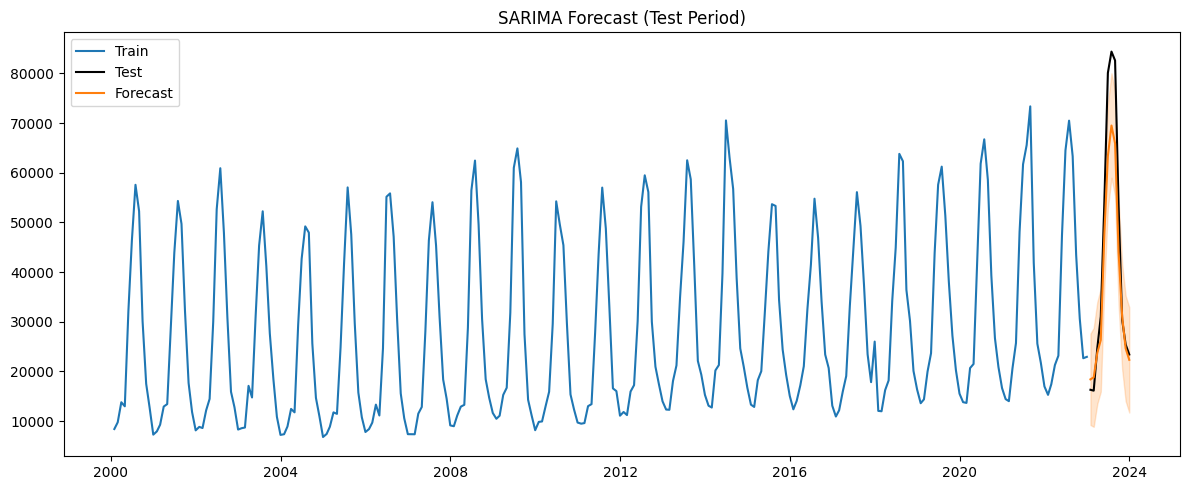

In [18]:
from sklearn.metrics import mean_absolute_error, mean_squared_error

# Forecast untuk periode test
forecast_res = best_model.get_forecast(steps=len(y_test))
y_pred = forecast_res.predicted_mean
conf_int = forecast_res.conf_int()

# Metrics
mae = mean_absolute_error(y_test, y_pred)
rmse = float(np.sqrt(mean_squared_error(y_test, y_pred)))
denom = np.where(np.abs(y_test.values) < 1e-12, np.nan, y_test.values)
mape = float(np.nanmean(np.abs((y_test.values - y_pred.values) / denom)) * 100)

print(f"MAE : {mae:,.3f}")
print(f"RMSE: {rmse:,.3f}")
print(f"MAPE: {mape:,.2f}%")

# Plot train / test / forecast
plt.figure(figsize=(12, 5))
plt.plot(y_train.index, y_train, label='Train')
plt.plot(y_test.index, y_test, label='Test', color='black')
plt.plot(y_pred.index, y_pred, label='Forecast', color='tab:orange')
plt.fill_between(conf_int.index, conf_int.iloc[:, 0], conf_int.iloc[:, 1], color='tab:orange', alpha=0.2)
plt.title('SARIMA Forecast (Test Period)')
plt.legend()
plt.tight_layout()
plt.show()

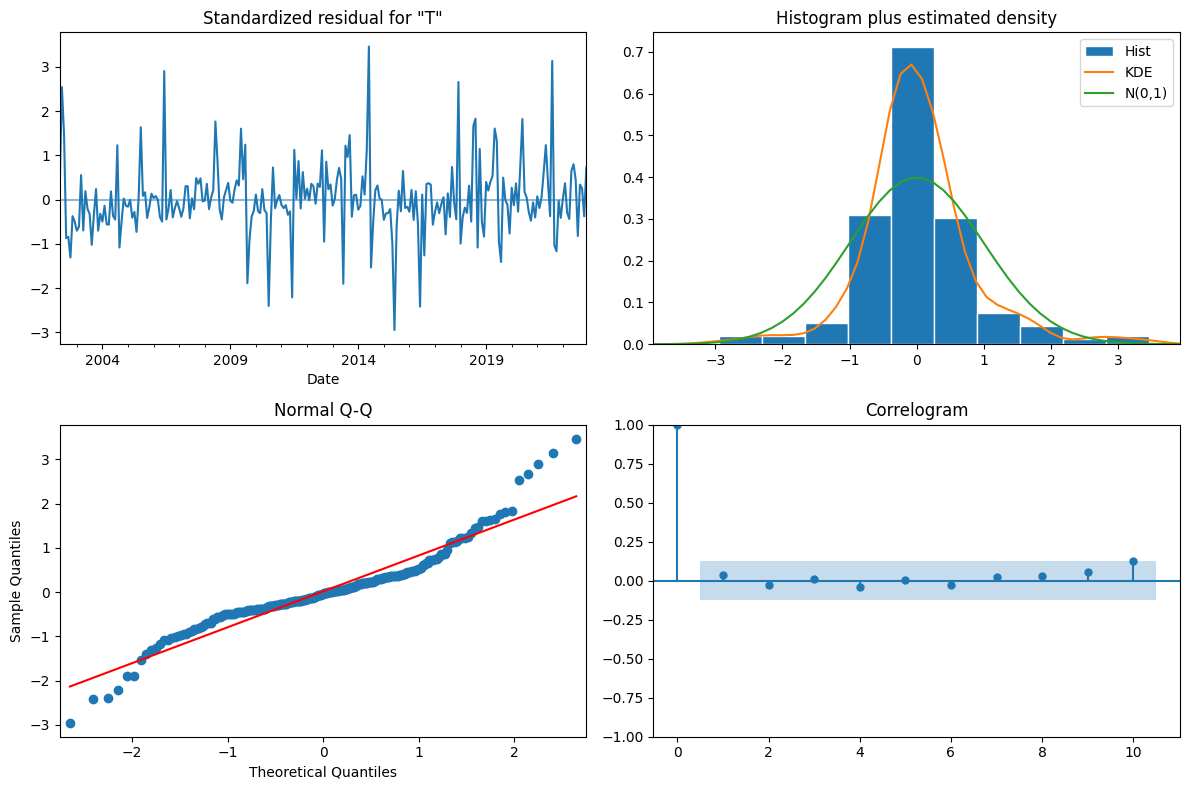

In [19]:
# Diagnostic plot untuk cek residual (white noise / normality / autocorrelation)
best_model.plot_diagnostics(figsize=(12, 8))
plt.tight_layout()
plt.show()

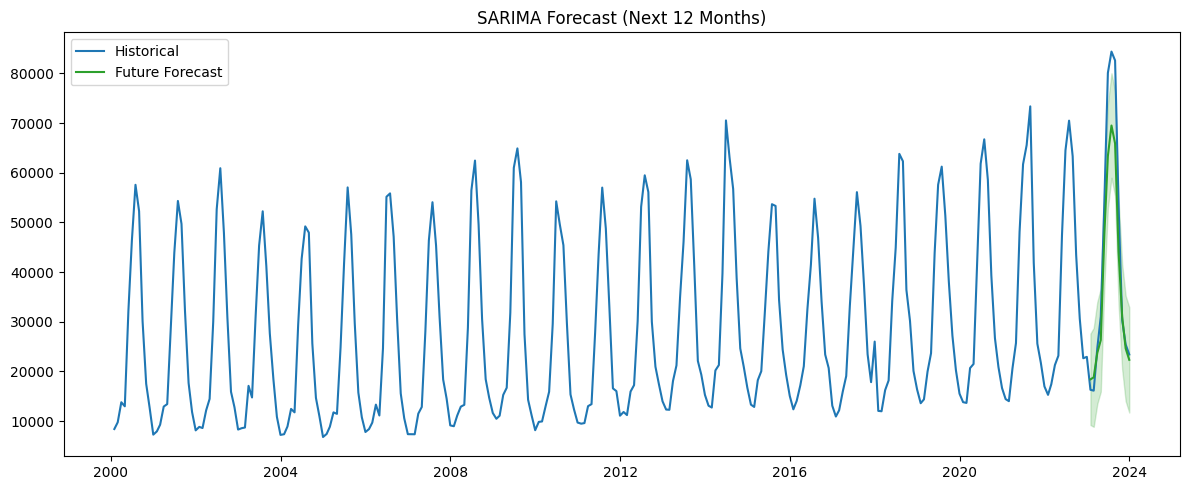

2023-01-31    18413.259705
2023-02-28    18806.761348
2023-03-31    23737.727611
2023-04-30    26323.466126
2023-05-31    47730.528369
Freq: ME, Name: predicted_mean, dtype: float64

In [20]:
# Forecast ke depan (misal 12 bulan) setelah akhir data
steps_ahead = 12
future_res = best_model.get_forecast(steps=steps_ahead)
future_pred = future_res.predicted_mean
future_ci = future_res.conf_int()

plt.figure(figsize=(12, 5))
plt.plot(y.index, y, label='Historical')
plt.plot(future_pred.index, future_pred, label='Future Forecast', color='tab:green')
plt.fill_between(future_ci.index, future_ci.iloc[:, 0], future_ci.iloc[:, 1], color='tab:green', alpha=0.2)
plt.title('SARIMA Forecast (Next 12 Months)')
plt.legend()
plt.tight_layout()
plt.show()

future_pred.head()